In [140]:
import os

from scipy.io import readsav
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import requests
from bs4 import BeautifulSoup

import urllib.request
#from urllib import urlopen

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

Read in SEP event list

In [141]:
#read in the shuffled dataframe of original sep+ctrl events from 1986 - 2004
#orig_data = pd.read_csv("AllEvtsShuffled_1986_2004.csv")

#read in the original Balch SEP event list with added CME speed and GOES T and EM
#orig_data = pd.read_excel("ctrlevents.v8p.xls")

#read in the shuffled dataframe of original sep+ctrl events from 1986 - 2004
data = pd.read_csv("AllEvtsShuffled_1986_2004_t_em_1MHz.csv")

data.FlrOnset = pd.to_datetime(data.FlrOnset)
data.Flrendtime = pd.to_datetime(data.Flrendtime)
data.Flrmaxtime = pd.to_datetime(data.Flrmaxtime)

#unshuffle the data
data.sort_values(by = 'FlrOnset', inplace = True)
data.reset_index(inplace = True)
data.drop(columns = ['index', 'Unnamed: 0'], inplace = True)

#only look for RSTN data from 1995 onwards i.e. the time frame when Wind WAVES 1 MHz data is available
data = data[['FlrOnset','Flrmaxtime', 'Flrendtime','FlrPeakFlux','FlrIntFlux2','TypeII','TypeIV',\
             'optlocation','FlrIntFlux','tchianti','emchianti','1MHz_fluence','sep']]
data = data.dropna(how='any')

print("length data set: Total: %i, No Seps: %i Sep: %i" % \
     (len(data), len(data.query('sep == 0.0')), len(data.query('sep == 1.0'))))


length data set: Total: 1181, No Seps: 1121 Sep: 60


Read in RSTN burst catalog (sorted by Nita alg)

In [142]:
# #read in IDL save file
# rstn_dict = readsav('sorted_rstn_data.sav')
# cols = list(rstn_dict)

# #some error abotu big endian compiler when reading directly from rstn dict
# #convert to pandas dataframe via numpy array
# x = np.array([rstn_dict['sort_event_class'],\
#      rstn_dict['sort_event_alpha'],\
#      rstn_dict['sort_event_start'],\
#      rstn_dict['sort_event_description'],\
#      rstn_dict['sort_event_duration'],\
#      rstn_dict['sort_event_dur_qual'],\
#      rstn_dict['sort_event_peak_hhmm'],\
#      rstn_dict['sort_event_peak_ss'],\
#      rstn_dict['sort_event_peak_qual'],\
#      rstn_dict['sort_event_station'],\
#      rstn_dict['sort_event_frequency'],\
#      rstn_dict['sort_event_peak_flux'],\
#      rstn_dict['sort_event_peak_flux_qual'],\
#      rstn_dict['sort_event_mean_flux'],\
#      rstn_dict['sort_event_mean_qual'],\
#      rstn_dict['sort_event_intensity'],\
#      rstn_dict['sort_event_numeric']])

# rstn = pd.DataFrame(x.transpose(), columns=cols)

# #select 1980s onwards
# rstn = rstn.iloc[200000::]

# #convert start time to datetime
# rstn.sort_event_start = pd.to_datetime(rstn.sort_event_start.str.decode("utf-8"), format ="%Y-%m-%d %H:%M:%S", errors = 'coerce')

# #convert station name to string
# rstn.sort_event_station = rstn.sort_event_station.str.decode('utf-8')

Read in the Raw RSTN burst catalog (unsorted into events)


In [143]:
#read in IDL save file
rstn_dict0 = readsav('rstn_data.sav')
cols0 = list(rstn_dict0)

#some error abotu big endian compiler when reading directly from rstn dict
#convert to pandas dataframe via numpy array
x0 = np.array([rstn_dict0['event_alpha'],\
     rstn_dict0['event_start'],\
     rstn_dict0['event_st_qual'],\
     rstn_dict0['event_description'],\
     rstn_dict0['event_duration'],\
     rstn_dict0['event_dur_qual'],\
     rstn_dict0['event_peak_hhmm'],\
     rstn_dict0['event_peak_ss'],\
     rstn_dict0['event_peak_qual'],\
     rstn_dict0['event_station'],\
     rstn_dict0['event_frequency'],\
     rstn_dict0['event_peak_flux'],\
     rstn_dict0['event_peak_flux_qual'],\
     rstn_dict0['event_mean_flux'],\
     rstn_dict0['event_mean_qual'],\
     rstn_dict0['event_intensity'],\
     rstn_dict0['event_numeric']])

rstn0 = pd.DataFrame(x0.transpose(), columns=cols0)

#select 1980s onwards
#rstn = rstn.iloc[200000::]

#convert start time to datetime
rstn0.event_start = pd.to_datetime(rstn0.event_start.str.decode("utf-8"), format ="%Y-%m-%d %H:%M:%S", errors = 'coerce')
rstn0.event_start = pd.to_datetime(rstn0.event_start, "%Y-%m-%dT%H:%M:%S.%MS")

#drop observations where the event duration is only 1 minute
rstn0 = rstn0.query("event_duration > 1")

#add end time column. Start time + duration
rstn0['event_end'] = rstn0['event_start'] + pd.to_timedelta(rstn0.event_duration,'m')



#convert station name to string
rstn0.event_station = rstn0.event_station.str.decode('utf-8')
rstn0.event_description = rstn0.event_description.str.decode('utf-8')
rstn0.event_st_qual = rstn0.event_st_qual.str.decode('utf-8')
rstn0.event_dur_qual = rstn0.event_dur_qual.str.decode('utf-8')
rstn0.event_peak_flux_qual = rstn0.event_peak_flux_qual.str.decode('utf-8')
rstn0.event_peak_qual = rstn0.event_peak_qual.str.decode('utf-8')

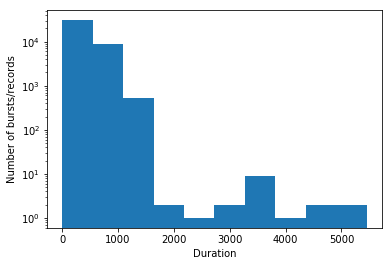

In [144]:
tst = rstn0.query("event_description == 'NS '")


#plt.hist(rstn0.event_duration)
plt.hist(tst.event_duration)
plt.xlabel('Duration')
plt.ylabel('Number of bursts/records')
plt.yscale('log')
plt.show()

In [147]:
rstn0.event_description.unique()

array(['   ', 'C  ', 'SER', 'F  ', 'GB ', 'NS ', 'RF ', 'S  ', 'S/F',
       'PBI', 'GRF', 'PRE', 'ABS', 'R  ', 'FAL', 'BPI', '8ER'], dtype=object)

In [148]:
rstn0.event_peak_qual.unique()

array([' ', 'U', 'D', 'E'], dtype=object)

Case study looking at the last SEP event in the Balch list

In [149]:
seps = data.query('sep == 1.0')
#i = 1
#print(seps.iloc[i].FlrOnset, seps.iloc[i].Flrendtime) 

In [9]:
# seps = data.query('sep == 1.0')

# for i in range(len(seps)):
#     rstn_analysis(seps.iloc[i])

In [155]:
# def integration_range2(flare_st, flare_et, df_obs, rstn_flare, obs = 'SVTO'):

#     #get all the bursts reported in rstn catalog for this flare
#     rstn_burst_freq_list = ['f' + s for s in np.sort(rstn_flare.event_frequency.unique()).astype('str')]
    
#     #what freqs are available at the given observatory
#     obs_freq_list= list(df_obs.columns)
    
#     #intersection of previous 2 lists
#     int_range_cols = list(set(rstn_burst_freq_list).intersection(obs_freq_list))

#     #loop through frequencies and append to dataframe the start and end of the integration times
#     df = pd.DataFrame(0, index=[0,1], columns=int_range_cols)
#     for f in int_range_cols:
        
#         #integrate start time
#         burst_start_times = rstn_flare.query('event_station == "'+obs+'" and \
#             event_frequency == '+f[1::]+' and event_start >= "'+ datetime.strftime(flare_st, "%Y-%m-%dT%H:%M:%S") + '"' ).event_start
#         if len(burst_start_times) > 0:
#             burst_start_times = pd.to_datetime(burst_start_times, "%Y-%m-%dT%H:%M:%S.%MS")
#             earliest_burst_ind = np.argmin(list(np.abs(burst_start_times - flare_st)))
#             integrate_start = burst_start_times.iloc[earliest_burst_ind]
#         else:
#             integrate_start = flare_st

#         #integrate end time
#         burst_end_times = rstn_flare.query('event_station == "'+obs+'" and \
#             event_frequency == '+f[1::]+' and event_end <= "'+ datetime.strftime(flare_et, "%Y-%m-%dT%H:%M:%S") + '"' ).event_end
#         if len(burst_end_times) > 0:
#             burst_end_times = pd.to_datetime(burst_end_times, "%Y-%m-%dT%H:%M:%S.%MS")
#             latest_burst_ind = np.argmin(list(np.abs(flare_et - burst_end_times)))
#             integrate_end = burst_end_times.iloc[latest_burst_ind]
#         else:
#             integrate_end = flare_et

#         tmp_df = pd.DataFrame({f: [integrate_start, integrate_end]})
#         df[f] = tmp_df[f]
            
#     return df



   


def integration_range(flare_st, flare_et, df_obs, rstn_flare, obs = 'SVTO'):
    
    """Define the integration time range of RSTN bursts at each frequency observed by the observatory"""

    #get all the bursts reported in rstn catalog for this flare
    rstn_burst_freq_list = ['f' + s for s in np.sort(rstn_flare.event_frequency.unique()).astype('str')]
    
    #what freqs are available at the given observatory
    obs_freq_list= list(df_obs.columns)
    obs_freq_list = list(filter(lambda s: s[0] == 'f', obs_freq_list))
    
    #intersection of previous 2 lists
    #int_range_cols = list(set(rstn_burst_freq_list).intersection(obs_freq_list)) #breaks if no burst list means you can't sum over flare                                                                     
    int_range_cols = obs_freq_list
    
    #flare end time plus an hour
    flare_et_plus_hour = flare_et + timedelta(seconds = 60*60)
    
    #loop through frequencies and append to dataframe the start and end of the integration times
    df = pd.DataFrame(0, index=[0,1], columns=obs_freq_list)
    for f in int_range_cols:
        
        #for now only integrate over 8800 MHz and 15400 MHz
        if np.logical_or((f == 'f8800'),(f == 'f15400')):

            #bursts starting after the flare start time, sorted by event start time
            bursts = rstn_flare.query('event_station == "'+obs+'" and event_frequency == '+f[1::]+' \
                and event_start >= "'+ datetime.strftime(flare_st, "%Y-%m-%dT%H:%M:%S") + '"' )\
                .sort_values('event_start')

            #drop rows where event_frequency, start, end and duration are the same
            bursts.drop_duplicates(subset = ['event_frequency','event_start','event_end','event_duration'], inplace = True)
                
            #for multiple bursts - check for overlapping bursts
            #print(len(bursts))
            #print(bursts[['event_frequency','event_start','event_end','event_duration']])

            new_bursts = []
#             if len(bursts) > 1:

#                 bursts.event_start = pd.to_datetime(bursts.event_start, "%Y-%m-%dT%H:%M:%S.%MS")
#                 bursts.event_end = pd.to_datetime(bursts.event_end, "%Y-%m-%dT%H:%M:%S.%MS")
                
#                 #loop through bursts and check to see if it overlaps previous burst
#                 for i in range(1, len(bursts)):

#                     #if the bursts overlap then merge these 2 bursts
#                     if bursts.event_start.iloc[i] <= bursts.event_end.iloc[i-1]:
#                         #also compare with previous new_bursts row in case multuple overlapping records
#                         if len(new_bursts) > 0: 
#                             if bursts.event_start.iloc[i] <= new_bursts[-1][1]:
#                                 new_bursts[-1][1] = bursts.event_end.iloc[i]
#                             else:
#                                 new_bursts.append([bursts.event_start.iloc[i-1], bursts.event_end.iloc[i]])
#                         else:
#                             #if the current burst is overlapping but it's end time is one hour longer than flare
#                             #ignore it and stick with the original burst time
#                             if bursts.event_end.iloc[i] > flare_et_plus_hour:
#                                 new_bursts.append([bursts.event_start.iloc[i-1], bursts.event_end.iloc[i-1]])
#                             else:
#                                 new_bursts.append([bursts.event_start.iloc[i-1], bursts.event_end.iloc[i]])

#                     #if they don't merge then the previous burst is separate
#                     else:
#                         new_bursts.append([bursts.event_start.iloc[i-1], bursts.event_end.iloc[i-1]])  
                        
#                     #if the last rstn burst end time exceeds the flare end time by more than an hour
#                     #then set the last burst end time to be the previous burst end time
#                     flare_et_plus_hour = flare_et + timedelta(seconds = 60*60)
#                     if new_bursts[-1][1] > flare_et_plus_hour:

#                         #get rid of any bursts that end more than 60 mins after flare end time
#                         tmp_bursts = bursts.query('event_end < "'+ \
#                                         datetime.strftime(flare_et_plus_hour, "%Y-%m-%dT%H:%M:%S") + '"')\
#                                         .sort_values(by = 'event_end')

#                         new_bursts[-1][1] = tmp_bursts.event_end.iloc[-1]
                        
    
    
#                 #now append the last burst if it's end time is within flare time
#                 if bursts.event_end.iloc[-1] < flare_et_plus_hour:
#                     new_bursts.append([bursts.event_start.iloc[-1], bursts.event_end.iloc[-1]])
            
#             elif len(bursts) == 1:
                
#                 #only one burst in the catalog so just use that
#                 new_bursts.append([bursts.event_start.iloc[0], bursts.event_end.iloc[0]])

#             else:
                
            #####FROM HERE    
                
            #if there are no bursts then don't want to integrate at all so set start and end to flare_st
            new_bursts.append([flare_st, flare_et])

            #check that integration start and end times cover the period for which there is data
            if flare_st < df_obs.date.iloc[0]:
                new_bursts[0][0] = df_obs.date.iloc[0] + timedelta(seconds = 60.*60.)  #extra hour to avoid bad data
            if flare_et > (df_obs.date.iloc[-1] + timedelta(seconds = 1.)):
                new_bursts[0][1] = df_obs.date.iloc[-1] - timedelta(seconds = 60.*60.) #extra hour to avoid bad data

                
            ###TO HERE### was inside the else    
                
            #for now just take the longest burst as the integration time  
            #print(new_bursts)
            
            burst_lengths = [(b[1]-b[0]).seconds for b in new_bursts]
            max_burst_ind = np.argmax(burst_lengths)
            #print(burst_lengths, max_burst_ind)
            
            tmp_df = pd.DataFrame({f: new_bursts[max_burst_ind]})
            df[f] = tmp_df[f]
            
    return df

            
def integrate_burst(df_obs, int_range):
    
    """Integrate the radio flux for each burst at each frequencey for the given observatory"""

    
    #what freqs are available at the given observatory
    obs_freq_list= list(df_obs.columns)
    obs_freq_list = list(filter(lambda s: s[0] == 'f', obs_freq_list))
    
    #loop through frequencies and append to dataframe the bkg level
    df_int = pd.DataFrame(0, index=[0], columns=obs_freq_list)
    df_bkg = pd.DataFrame(0, index=[0], columns=obs_freq_list)
    
    #loop through frequencies
    for f in int_range.columns:
        
        #for now only look at 8800 and 15400 MHz
        if np.logical_or((f == 'f8800'),(f == 'f15400')):
            
            #integration start and end times
            int_st = int_range[f][0]
            int_et = int_range[f][1]
            
            #print(f)
            #print(int_st, int_et)
            #print(df_obs.date.iloc[0], df_obs.date.iloc[-1])
            
            #bkg = flux level at time interval before intergration start time
            #print(df_obs.query('date < "'+ datetime.strftime(int_st, "%Y-%m-%dT%H:%M:%S") + '"')[f])
            df_bkg[f] = df_obs.query('date < "'+ datetime.strftime(int_st, "%Y-%m-%dT%H:%M:%S") + '"')[f].iloc[-1]
            
            #subset of data for integrating
            int_data = df_obs.query('date >= "'+ datetime.strftime(int_st, "%Y-%m-%dT%H:%M:%S") + '" and date <= "' + \
                         datetime.strftime(int_et, "%Y-%m-%dT%H:%M:%S") + '"')[f]

            #background subtracted data for integration time period
            int_data_bkgsub = int_data - df_bkg[f].values[0]
            
            #integrated flux
            df_int[f] = int_data_bkgsub.sum()
    
    return df_int, df_bkg


def RSTN_peak_flux(flare_st, flare_et, df_obs, obs = 'SVTO'):
 
    """Peak radio flux for each frequencey for the given observatory"""

    #what freqs are available at the given observatory
    obs_freq_list= list(df_obs.columns)
    obs_freq_list = list(filter(lambda s: s[0] == 'f', obs_freq_list))
    
    #loop through frequencies and append to dataframe the bkg level
    df_peak = pd.DataFrame(0, index=[0], columns=obs_freq_list)
    
    #loop through frequencies
    for f in obs_freq_list:
        
        #for now only look at 8800 and 15400 MHz
        if np.logical_or((f == 'f8800'),(f == 'f15400')):
            
            #print(f)
            #print(flare_st, flare_et)
            #print(df_obs.date.iloc[0], df_obs.date.iloc[-1])

            #subset of data for integrating
            flare_data = df_obs.query('date >= "'+ datetime.strftime(flare_st, "%Y-%m-%dT%H:%M:%S") + '" and date <= "' + \
                         datetime.strftime(flare_et, "%Y-%m-%dT%H:%M:%S") + '"')[f]

            #integrated flux
            df_peak[f] = flare_data.max()
    
    return df_peak

    
def rstn_analysis(event, peak_calc = 1, plot = 1):
    
    """RSTN analysis for each event"""

    #flare start and end
    flare_st = event.FlrOnset
    flare_et = event.Flrendtime
    
    #get RSTN time profiles
    df_lear = read_rstn(event, obs = 'learmonth', trim = 1)
    df_pale = read_rstn(event, obs = 'palehua', trim = 1)
    df_saga = read_rstn(event, obs = 'sagamore-hill', trim = 1)
    df_sanv = read_rstn(event, obs = 'san-vito', trim = 1)

    #get the RSTN radio bursts recorded during the flare
    rstn_flare = rstn0[(rstn0['event_start'] > datetime.strftime(event.FlrOnset, "%Y-%m-%d %H:%M:%S")) \
         & (rstn0['event_start'] < datetime.strftime(event.Flrendtime, "%Y-%m-%d %H:%M:%S"))]

    #what observatories saw bursts
    lear_burst = rstn_flare.query('event_station == "LEAR"')
    pale_burst = rstn_flare.query('event_station == "PALE"')
    saga_burst = rstn_flare.query('event_station == "SGMR"')
    sanv_burst = rstn_flare.query('event_station == "SVTO"')

    print(len(df_lear), len(df_pale), len(df_saga), len(df_sanv))
    print(len(lear_burst), len(pale_burst), len(saga_burst), len(sanv_burst))
    
    #if there is no data for the time range quit and return empty dataframe
    if (len(df_lear) + len(df_pale) + len(df_saga) + len(df_sanv) ) == 0:
        df_flare_burst_int = pd.DataFrame({'f8800':np.nan,'obs_f8800':'NaN','int_st_f8800':np.nan,\
                                           'int_et_f8800':np.nan, 'f15400':np.nan,'obs_f15400':'NaN',\
                                           'int_st_f15400':np.nan,'int_et_f15400':np.nan}, index=[0])
        return df_flare_burst_int
        
    
    if peak_calc == 1:
        
        #dataframe with the peak fluxes from each observatory
        df_flare_peak = pd.DataFrame(columns=['obs','f8800','f15400'])
        if len(df_lear) > 1:
            df_peak_lear = RSTN_peak_flux(flare_st, flare_et, df_lear, obs = 'LEAR')
            df_flare_peak = df_flare_peak.append({'obs':'lear', 
                                                'f8800': df_peak_lear.f8800.values[0],
                                                'f15400': df_peak_lear.f15400.values[0]}, 
                                                 ignore_index=True)
                
        if len(df_pale) > 1:
            df_peak_pale = RSTN_peak_flux(flare_st, flare_et, df_pale, obs = 'PALE')
            df_flare_peak = df_flare_peak.append({'obs':'pale', 
                                    'f8800': df_peak_pale.f8800.values[0],
                                    'f15400': df_peak_pale.f15400.values[0]}, 
                                     ignore_index=True)
            
        if len(df_saga) > 1:
            df_peak_saga = RSTN_peak_flux(flare_st, flare_et, df_saga, obs = 'SGMR')
            df_flare_peak = df_flare_peak.append({'obs':'saga', 
                                    'f8800': df_peak_saga.f8800.values[0],
                                    'f15400': df_peak_saga.f15400.values[0]}, 
                                    ignore_index=True)
            
        
        if len(df_sanv) > 1:
            df_peak_sanv = RSTN_peak_flux(flare_st, flare_et, df_sanv, obs = 'SVTO')  
            df_flare_peak = df_flare_peak.append({'obs':'sanv', 
                                    'f8800': df_peak_sanv.f8800.values[0],
                                    'f15400': df_peak_sanv.f15400.values[0]}, 
                                     ignore_index=True)
          
        
        df_flare_peak.f8800 = df_flare_peak.f8800.astype('int')
        df_flare_peak.f15400 = df_flare_peak.f15400.astype('int')
    
        df_peak = pd.DataFrame({ 'f8800': df_flare_peak.iloc[df_flare_peak.f8800.idxmax()].f8800,
                            'obs_f8800': df_flare_peak.iloc[df_flare_peak.f8800.idxmax()].obs,
                            'f15400' : df_flare_peak.iloc[df_flare_peak.f15400.idxmax()].f15400,
                            'obs_f15400': df_flare_peak.iloc[df_flare_peak.f15400.idxmax()].obs}, \
                            index = [0])

    
    #there must be data and RSTN bursts recording during the flare to continue
    df_int_lear = None
    #if np.logical_and((len(df_lear) > 1), (len(lear_burst > 0))):
    if len(df_lear) > 1:
        
        #get integration times
        int_range_lear = integration_range(flare_st, flare_et, df_lear, rstn_flare, obs = 'LEAR')
        #int_range_lear = pd.DataFrame({'f8800':[flare_st, flare_et], 'f15400':[flare_st, flare_et]})
        
        #subtract background flux and integrated over time interval
        df_int_lear, df_bkg_lear = integrate_burst(df_lear, int_range_lear)
        #print(df_bkg_lear)
        #print(df_int_lear)

        if plot == 1:
            plot_rstn_burst_obs(df_lear, rstn_flare, event.FlrOnset, event.Flrendtime, "LEAR", \
                        lines = int_range_lear, hlines = df_bkg_lear)

    df_int_pale = None
    #if np.logical_and((len(df_pale) > 1), (len(pale_burst > 0))):
    if len(df_pale) > 1:
        
        #get integration times
        int_range_pale = integration_range(flare_st, flare_et, df_pale, rstn_flare, obs = 'PALE')
        #int_range_pale = pd.DataFrame({'f8800':[flare_st, flare_et], 'f15400':[flare_st, flare_et]})
        
        #subtract background flux and integrated over time interval
        df_int_pale, df_bkg_pale = integrate_burst(df_pale, int_range_pale)
        #print(df_bkg_pale)
        #print(df_int_pale)

        if plot == 1:
            plot_rstn_burst_obs(df_pale, rstn_flare, event.FlrOnset, event.Flrendtime, "PALE", \
                        lines = int_range_pale, hlines = df_bkg_pale)

    df_int_saga = None
    #if np.logical_and((len(df_saga) > 1), (len(saga_burst > 0))):
    if len(df_saga) > 1:

        #get integration times
        int_range_saga = integration_range(flare_st, flare_et, df_saga, rstn_flare, obs = 'SGMR')
        #int_range_saga = pd.DataFrame({'f8800':[flare_st, flare_et], 'f15400':[flare_st, flare_et]})
        #print(int_range_saga)
        
        #subtract background flux and integrated over time interval
        df_int_saga, df_bkg_saga = integrate_burst(df_saga, int_range_saga)
        #print(df_bkg_saga)
        #print(df_int_saga)
        
        if plot == 1:
            plot_rstn_burst_obs(df_saga, rstn_flare, event.FlrOnset, event.Flrendtime, "SGMR", \
                        lines = int_range_saga, hlines = df_bkg_saga)

    df_int_sanv = None
    #if np.logical_and((len(df_sanv) > 1), (len(sanv_burst > 0))):   
    if len(df_sanv) > 1:

        #get integration times
        int_range_sanv = integration_range(flare_st, flare_et, df_sanv, rstn_flare, obs = 'SVTO')
        #int_range_sanv = pd.DataFrame({'f8800':[flare_st, flare_et], 'f15400':[flare_st, flare_et]})
        
        #subtract background flux and integrated over time interval
        df_int_sanv, df_bkg_sanv = integrate_burst(df_sanv, int_range_sanv)
        #print(df_bkg_sanv)
        #print(df_int_sanv)
        
        if plot == 1:
            plot_rstn_burst_obs(df_sanv, rstn_flare, event.FlrOnset, event.Flrendtime, "SVTO" , \
                        lines = int_range_sanv, hlines = df_bkg_sanv)
    
    
#     #which burst would the code chose to use for int flux
#     df_obs_bursts = pd.DataFrame(columns=['obs','f8800','f15400'])
#     if df_int_lear is not None:
#         df_obs_bursts = df_obs_bursts.append({'obs':'lear', 'f8800':df_int_lear.f8800.values[0],\
#                             'f15400':df_int_lear.f15400.values[0]}, ignore_index=True)
#     if df_int_pale is not None:
#         df_obs_bursts = df_obs_bursts.append({'obs':'pale', 'f8800':df_int_pale.f8800.values[0],\
#                             'f15400':df_int_pale.f15400.values[0]}, ignore_index=True)
#     if df_int_saga is not None:
#         df_obs_bursts = df_obs_bursts.append({'obs':'saga', 'f8800':df_int_saga.f8800.values[0], \
#                             'f15400':df_int_saga.f15400.values[0]}, ignore_index=True)
#     if df_int_sanv is not None:
#         df_obs_bursts = df_obs_bursts.append({'obs':'sanv', 'f8800':df_int_sanv.f8800.values[0], \
#                             'f15400':df_int_sanv.f15400.values[0]}, ignore_index=True)
    
#     df_obs_bursts.f8800 = df_obs_bursts.f8800.astype('int')
#     df_obs_bursts.f15400 = df_obs_bursts.f15400.astype('int')
  
#     #record burst integrated flux for 8800 and 15400 
#     df_flare_burst_int = pd.DataFrame(columns=['f8800','obs_f8800','int_st_f8800','int_et_f8800', \
#                                                'f15400','obs_f15400','int_st_f15400','int_et_f15400'])

#     #get the st and et for f8800
#     if df_obs_bursts.iloc[df_obs_bursts.f8800.idxmax()].obs == 'lear':
#         f8800_st = int_range_lear.f8800.iloc[0]
#         f8800_et = int_range_lear.f8800.iloc[1]
#     elif df_obs_bursts.iloc[df_obs_bursts.f8800.idxmax()].obs == 'pale':
#         f8800_st = int_range_pale.f8800.iloc[0]
#         f8800_et = int_range_pale.f8800.iloc[1]
#     elif df_obs_bursts.iloc[df_obs_bursts.f8800.idxmax()].obs == 'saga':
#         f8800_st = int_range_saga.f8800.iloc[0]
#         f8800_et = int_range_saga.f8800.iloc[1]
#     elif df_obs_bursts.iloc[df_obs_bursts.f8800.idxmax()].obs == 'sanv':
#         f8800_st = int_range_sanv.f8800.iloc[0]
#         f8800_et = int_range_sanv.f8800.iloc[1]
        
#     #get the st and et for f15400
#     if df_obs_bursts.iloc[df_obs_bursts.f15400.idxmax()].obs == 'lear':
#         f15400_st = int_range_lear.f15400.iloc[0]
#         f15400_et = int_range_lear.f15400.iloc[1]
#     elif df_obs_bursts.iloc[df_obs_bursts.f15400.idxmax()].obs == 'pale':
#         f15400_st = int_range_pale.f15400.iloc[0]
#         f15400_et = int_range_pale.f15400.iloc[1]
#     elif df_obs_bursts.iloc[df_obs_bursts.f15400.idxmax()].obs == 'saga':
#         f15400_st = int_range_saga.f15400.iloc[0]
#         f15400_et = int_range_saga.f15400.iloc[1]
#     elif df_obs_bursts.iloc[df_obs_bursts.f15400.idxmax()].obs == 'sanv':
#         f15400_st = int_range_sanv.f15400.iloc[0]
#         f15400_et = int_range_sanv.f15400.iloc[1]
    
    
#     df_flare_burst_int = df_flare_burst_int.append({ 'f8800': df_obs_bursts.iloc[df_obs_bursts.f8800.idxmax()].f8800,
#                             'obs_f8800': df_obs_bursts.iloc[df_obs_bursts.f8800.idxmax()].obs,
#                             'int_st_f8800': f8800_st, 
#                             'int_et_f8800': f8800_et, 
                              
#                             'f15400' : df_obs_bursts.iloc[df_obs_bursts.f15400.idxmax()].f15400,
#                             'obs_f15400': df_obs_bursts.iloc[df_obs_bursts.f15400.idxmax()].obs,
#                             'int_st_f15400': f15400_st, 
#                             'int_et_f15400': f15400_et }, \
#                             ignore_index=True)

    #return rstn_flare, df_lear, df_pale, df_saga, df_sanv, df_flare_burst_int
    #return df_flare_burst_int
    return df_peak

6706 0 0 4962
19 13 0 0


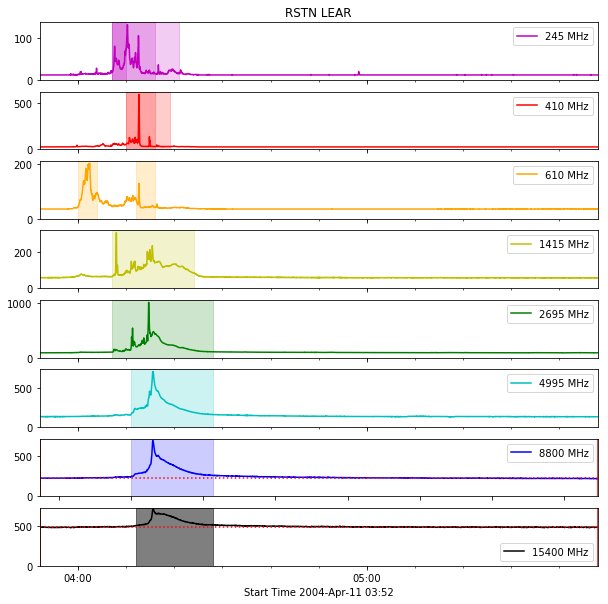

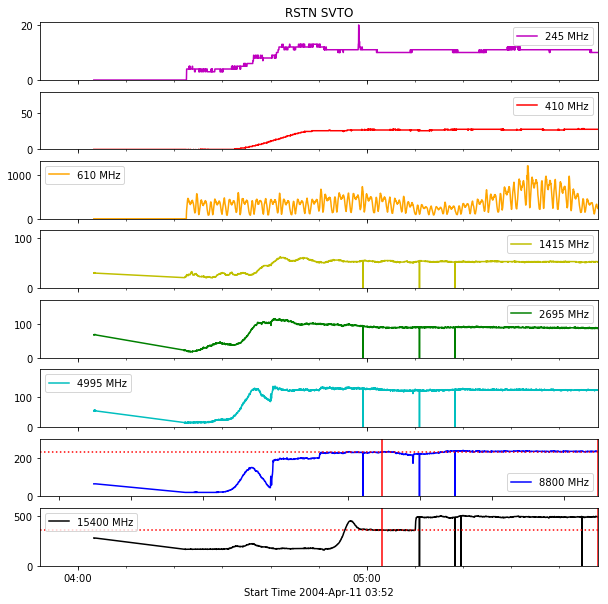

   f15400  f8800 obs_f15400 obs_f8800
0     721    696       lear      lear


In [156]:
i = -5
#print(seps.iloc[i])
#df_flare_burst_int0 = rstn_analysis(seps.iloc[i], plot = 1)
df_peak0 = rstn_analysis(seps.iloc[i], peak_calc= 1, plot = 1)

print(df_peak0)


In [16]:
for i in range(len(seps)):
    print(i)
    
    print(seps.iloc[i].FlrOnset)
    df_flare_burst_int0 = rstn_analysis(seps.iloc[i], plot = 0)

    if i == 0:
        df_flare_burst_int = df_flare_burst_int0
    else:
        df_flare_burst_int = df_flare_burst_int.append(df_flare_burst_int0)

0
1995-10-20 05:11:00
1
1997-11-04 05:51:00
2
1997-11-06 11:49:00
3
1998-05-02 13:27:00
4
1998-05-06 07:57:00
5
1998-08-24 21:21:00
6
1998-09-30 12:59:00
7
1999-06-04 06:49:00
8
2000-04-04 15:00:00
9
2000-06-06 14:58:00
/Users/hazelbain/data/RSTN_SW/2000_fixed/06JUN00.LIS: An error occured trying to read the file:/Users/hazelbain/data/RSTN_SW/2000_fixed/06JUN00.LIS
10
2000-06-10 16:31:00
/Users/hazelbain/data/RSTN_SW/2000_fixed/10JUN00.LIS: An error occured trying to read the file:/Users/hazelbain/data/RSTN_SW/2000_fixed/10JUN00.LIS
11
2000-07-14 10:03:00
/Users/hazelbain/data/RSTN_SW/2000_fixed/14JUL00.APL: An error occured trying to read the file:/Users/hazelbain/data/RSTN_SW/2000_fixed/14JUL00.APL
/Users/hazelbain/data/RSTN_SW/2000_fixed/14JUL00.LIS: An error occured trying to read the file:/Users/hazelbain/data/RSTN_SW/2000_fixed/14JUL00.LIS
12
2000-07-22 11:14:00
/Users/hazelbain/data/RSTN_SW/2000_fixed/22JUL00.APL: An error occured trying to read the file:/Users/hazelbain/data/RS

ValueError: attempt to get argmax of an empty sequence

### Util Functions

Get RSTN data for each event

In [150]:
def read_rstn(event, obs = 'learmonth', trim = 1):

    """Read RSTN data files from local data directiry"""

    #print(obs)
    
    day = str(event.FlrOnset.day).zfill(2)
    month = str(datetime.strftime(event.FlrOnset, "%b")).upper()
    year = str(event.FlrOnset.year)
    
    if obs == 'learmonth':
        obsstr = 'APL'
    elif obs == 'palehua':
        obsstr = 'PHF'
    elif obs == 'sagamore-hill':
        obsstr = 'K7O'
    elif obs == 'san-vito':
        obsstr = 'LIS'
    else:
        print("Unknown Observatory")
    
    #Get the radio data for the day of the start of the flare and read into dataframe
    path = "/Users/hazelbain/data/RSTN_SW/"+str(event.FlrOnset.year)+"_fixed/"    
    
    #find the first file in the directory 
    try:
        files = os.listdir(path) 
    except Exception as e:
        print(str(e)) 
        return pd.DataFrame()

    try:

        #parse code b
        filestr = day+month+year[2:4]+'.'+obsstr
        df = rstn_parse_a(path + filestr)

        #multiple files with day data
        #if len(file_ind) > 1:
            #do something

        if trim == 1:
            #trim the rstn data to the start and end of the flare
            st = event.FlrOnset - timedelta(seconds = 60.)    #take one data point before flare st for bkg sub
            et = event.Flrendtime

            #trim the RSTN data to times between st and et
            df = df[(df['date'] > datetime.strftime(st, "%Y-%m-%d %H:%M:%S")) \
                & (df['date'] < datetime.strftime(et, "%Y-%m-%d %H:%M:%S"))]

        return df
    except:
        return pd.DataFrame()

In [151]:
def rstn_parse_a(filepath):
    
        """RSTN parser code for files without header in the early 00s"""
    
        dt =[('datestr','S18'),('f245','i4'),('f410','i8'),('f610','i8'),('f1415','i8'),\
            ('f2695','i8'),('f4995','i8'),('f8800','i8'),('f15400','i8')]   
        
        try:
            data_start = np.genfromtxt(filepath, dtype = dt, delimiter = [18,6,6,6,6,6,6,6,6], filling_values = -999)          
            df = pd.DataFrame(data_start)
        except IOError:
            print(filepath + ': An error occured trying to read the file:' + filepath)
        except ValueError:
            print(filepath + ': Non-numeric data found in the file.')
        except Exception as e:
            print(filepath + ": Unknown exception occurred: " + str(e))           
        
        #convert times to datetime
        df.datestr = df.datestr.str.decode("utf-8")
        df['date'] = pd.to_datetime(df.datestr, format = str(df.datestr.iloc[0][0:4]) + "%Y%m%d%H%M%S") 
        
        return df

In [152]:
def rstn_parse_b(filepath):
    
    """RSTN parser code for files with header in the late 80s"""

    dt =[('datestr','S10'), ('timestr','S10'),('f245','f4'),('f410','f8'),('f610','f8'),('f1415','f8'),\
            ('f2695','f8'),('f4995','f8'),('f8800','f8'),('f15400','f8')]  
    
    try:
        data = np.genfromtxt(filepath, dtype = dt, skip_header = 23, skip_footer = 1, usecols = (1, 2, 4, 6, 8, 10, 12, 14, 16, 18))
        df = pd.DataFrame(data)
    except IOError:
        print(filepath + ': An error occured trying to read the file:' + url_start)
    except ValueError:
        print(filepath + ': Non-numeric data found in the file.')
    except Exception as e:
        print(filepath + ": Unknown exception occurred: " + str(e))

    #convert times to datetime
    df.datestr = df.datestr.str.decode("utf-8")
    df.timestr = df.timestr.str.decode("utf-8")
    df['date'] = pd.to_datetime(df.datestr + ' ' + df.timestr, format = "%m/%d/%Y %H:%M:%S") 
    
    return df

Plot RSTN radio burst for a given observatory

In [153]:
def plot_rstn_burst_obs(df, rstn_burst, st, et, obs, lines = pd.DataFrame(columns = ['f8800','f15400']),\
                        hlines = pd.DataFrame(columns = ['f8800','f15400'])):

    """Plot RSTN radio burst for a given observatory"""

    #print(hlines)
    
    rstn_color = ['m','r','orange','y','g','c','b','k']
    
    hours = mdates.HourLocator()  # every month
    minutes = mdates.MinuteLocator(byminute=np.arange(0,60,10))  # every month
    dateFmt = mdates.DateFormatter('%H:%M')

    f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(8,1, figsize = (10,10))


    ax1.plot(df.date, df.f245, c = 'm', label = '245 MHz')
    ax1.set_title('RSTN '+obs)
    ax1.set_ylim(bottom = 0)
    ax1.set_xlim(st, et)
    ax1.xaxis.set_major_locator(hours)
    ax1.xaxis.set_major_formatter(dateFmt)
    ax1.xaxis.set_minor_locator(minutes)
    ax1.set_xticklabels(' ')
    ax1.legend()
    rstn_burst_freq = rstn_burst.query("event_station == '"+obs+"' and event_frequency == 245 and event_duration > 0 and event_duration < 1000")
    if len(rstn_burst_freq) > 0:
        for b in range(len(rstn_burst_freq)):
            ax1.axvspan(rstn_burst_freq.event_start.iloc[b], rstn_burst_freq.event_start.iloc[b] + \
                timedelta(minutes = rstn_burst_freq.event_duration.iloc[b]), \
                alpha=0.2, color=rstn_color[0])
#     if lines.f245.iloc[0] != 0:
#         for l in lines.f245:
#             ax1.axvline(x = l, c = 'r')
#     if hlines.f245.iloc[0] != 0:
#         for l in hlines.f245:
#             ax1.axhline(y = l, c = 'r', linestyle = ':')
            
        
    ax2.plot(df.date, df.f410, c = 'r', label = '410 MHz')
    ax2.set_ylim(bottom = 0)
    ax2.set_xlim(st, et)
    ax2.xaxis.set_major_locator(hours)
    ax2.xaxis.set_major_formatter(dateFmt)
    ax2.xaxis.set_minor_locator(minutes)
    ax2.set_xticklabels(' ')
    ax2.legend()
    rstn_burst_freq = rstn_burst.query("event_station == '"+obs+"' and event_frequency == 410 and event_duration > 0 and event_duration < 1000")
    if len(rstn_burst_freq) > 0:
        for b in range(len(rstn_burst_freq)):
            ax2.axvspan(rstn_burst_freq.event_start.iloc[b], rstn_burst_freq.event_start.iloc[b] + \
                timedelta(minutes = rstn_burst_freq.event_duration.iloc[b]), \
                alpha=0.2, color=rstn_color[1])
#     if lines.f410.iloc[0] != 0:
#         for l in lines.f410:
#             ax2.axvline(x = l, c = 'r')
#     if hlines.f410.iloc[0] != 0:
#         for l in hlines.f410:
#             ax2.axhline(y = l, c = 'r', linestyle = ':')
            
            
    ax3.plot(df.date, df.f610, c = 'orange', label = '610 MHz')
    ax3.set_ylim(bottom = 0)
    ax3.set_xlim(st, et)
    ax3.xaxis.set_major_locator(hours)
    ax3.xaxis.set_major_formatter(dateFmt)
    ax3.xaxis.set_minor_locator(minutes)
    ax3.set_xticklabels(' ')
    ax3.legend()
    rstn_burst_freq = rstn_burst.query("event_station == '"+obs+"' and event_frequency == 610 and event_duration > 0 and event_duration < 1000")
    if len(rstn_burst_freq) > 0:
        for b in range(len(rstn_burst_freq)):
            ax3.axvspan(rstn_burst_freq.event_start.iloc[b], rstn_burst_freq.event_start.iloc[b] + \
                timedelta(minutes = rstn_burst_freq.event_duration.iloc[b]), \
                alpha=0.2, color=rstn_color[2])
#     if lines.f610.iloc[0] != 0:
#         for l in lines.f610:
#             ax3.axvline(x = l, c = 'r')
#     if hlines.f610.iloc[0] != 0:
#         for l in hlines.f610:
#             ax3.axhline(y = l, c = 'r', linestyle = ':')            

        
    ax4.plot(df.date, df.f1415, c = 'y', label = '1415 MHz')
    ax4.set_ylim(bottom = 0)
    ax4.set_xlim(st, et)
    ax4.xaxis.set_major_locator(hours)
    ax4.xaxis.set_major_formatter(dateFmt)
    ax4.xaxis.set_minor_locator(minutes)
    ax4.set_xticklabels(' ')
    ax4.legend()
    rstn_burst_freq = rstn_burst.query("event_station == '"+obs+"' and event_frequency == 1415 and event_duration > 0 and event_duration < 1000")
    if len(rstn_burst_freq) > 0:
        for b in range(len(rstn_burst_freq)):
            ax4.axvspan(rstn_burst_freq.event_start.iloc[b], rstn_burst_freq.event_start.iloc[b] + \
                timedelta(minutes = rstn_burst_freq.event_duration.iloc[b]), \
                alpha=0.2, color=rstn_color[3])
#     if lines.f1415.iloc[0] != 0:
#         for l in lines.f1415:
#             ax4.axvline(x = l, c = 'r')
#     if hlines.f1415.iloc[0] != 0:
#         for l in hlines.f1415:
#             ax4.axhline(y = l, c = 'r', linestyle = ':')            

    ax5.plot(df.date, df.f2695, c = 'g', label = '2695 MHz')
    ax5.set_ylim(bottom = 0)
    ax5.set_xlim(st, et)
    ax5.xaxis.set_major_locator(hours)
    ax5.xaxis.set_major_formatter(dateFmt)
    ax5.xaxis.set_minor_locator(minutes)
    ax5.set_xticklabels(' ')
    ax5.legend()
    rstn_burst_freq = rstn_burst.query("event_station == '"+obs+"' and event_frequency == 2695 and event_duration > 0 and event_duration < 1000")
    if len(rstn_burst_freq) > 0:
        for b in range(len(rstn_burst_freq)):
            ax5.axvspan(rstn_burst_freq.event_start.iloc[b], rstn_burst_freq.event_start.iloc[b] + \
                timedelta(minutes = rstn_burst_freq.event_duration.iloc[b]), \
                alpha=0.2, color=rstn_color[4])
#     if lines.f2695.iloc[0] != 0:
#         for l in lines.f2695:
#             ax5.axvline(x = l, c = 'r')
#     if hlines.f2695.iloc[0] != 0:
#         for l in hlines.f2695:
#             ax5.axhline(y = l, c = 'r', linestyle = ':')
            

    ax6.plot(df.date, df.f4995, c = 'c', label = '4995 MHz')
    ax6.set_ylim(bottom = 0)
    ax6.set_xlim(st, et)
    ax6.xaxis.set_major_locator(hours)
    ax6.xaxis.set_major_formatter(dateFmt)
    ax6.xaxis.set_minor_locator(minutes)
    ax6.set_xticklabels(' ')
    ax6.legend()
    rstn_burst_freq = rstn_burst.query("event_station == '"+obs+"' and event_frequency == 4995 and event_duration > 0 and event_duration < 1000")
    if len(rstn_burst_freq) > 0:
        for b in range(len(rstn_burst_freq)):
            ax6.axvspan(rstn_burst_freq.event_start.iloc[b], rstn_burst_freq.event_start.iloc[b] + \
                timedelta(minutes = rstn_burst_freq.event_duration.iloc[b]), \
                alpha=0.2, color=rstn_color[5])
#     if lines.f4995.iloc[0] != 0:
#         for l in lines.f4995:
#             ax6.axvline(x = l, c = 'r')
#     if hlines.f4995.iloc[0] != 0:
#         for l in hlines.f4995:
#             ax6.axhline(y = l, c = 'r', linestyle = ':')            


    if 'f8800' in df.columns:  
        ax7.plot(df.date, df.f8800, c = 'b', label = '8800 MHz')
        ax7.set_ylim(bottom = 0)
        ax7.set_xlim(st, et)
        ax7.set_xticklabels(' ')
        ax7.legend()
        rstn_burst_freq = rstn_burst.query("event_station == '"+obs+"' and event_frequency == 8800 and event_duration > 0 and event_duration < 1000")
        if len(rstn_burst_freq) > 0:
            for b in range(len(rstn_burst_freq)):
                ax7.axvspan(rstn_burst_freq.event_start.iloc[b], rstn_burst_freq.event_start.iloc[b] + \
                    timedelta(minutes = rstn_burst_freq.event_duration.iloc[b]), \
                    alpha=0.2, color=rstn_color[6])
        if lines.f8800.iloc[0] != 0:
            for l in lines.f8800:
                ax7.axvline(x = l, c = 'r')   
        if hlines.f8800.iloc[0] != 0:
            for l in hlines.f8800:
                ax7.axhline(y = l, c = 'r', linestyle = ':')
    else:
        ax7.axis('off')
        ax6.xaxis.set_major_locator(hours)
        ax6.xaxis.set_major_formatter(dateFmt)
        ax6.xaxis.set_minor_locator(minutes)
        ax6.set_xlabel('Start Time ' + datetime.strftime(st, "%Y-%b-%d %H:%M"))

    if 'f15400' in df.columns:     
        ax8.plot(df.date, df.f15400, c = 'k', label = '15400 MHz')
        ax8.set_ylim(bottom = 0)
        ax8.set_xlim(st, et)
        ax8.xaxis.set_major_locator(hours)
        ax8.xaxis.set_major_formatter(dateFmt)
        ax8.xaxis.set_minor_locator(minutes)
        ax8.set_xlabel('Start Time ' + datetime.strftime(st, "%Y-%b-%d %H:%M"))
        ax8.legend()
        rstn_burst_freq = rstn_burst.query("event_station == '"+obs+"' and event_frequency == 15400 and event_duration > 0 and event_duration < 1000")
        if len(rstn_burst_freq) > 0:
            for b in range(len(rstn_burst_freq)):
                ax8.axvspan(rstn_burst_freq.event_start.iloc[b], rstn_burst_freq.event_start.iloc[b] + \
                    timedelta(minutes = rstn_burst_freq.event_duration.iloc[b]), \
                    alpha=0.5, color=rstn_color[7])
        if lines.f15400.iloc[0] != 0:
            for l in lines.f15400:
                ax8.axvline(x = l, c = 'r') 
        if hlines.f15400.iloc[0] != 0:
            for l in hlines.f15400:
                ax8.axhline(y = l, c = 'r', linestyle = ':')
    else:
        ax8.axis('off')

    plt.show()

Plot all RSTN frequencies for each radio observatory for the time frame of the flare

In [154]:
def plot_rstn_burst(df_lear, df_pale, df_saga, df_sanv, st, et):
    
    """Plot all RSTN frequencies for each radio observatory for the time frame of the flare"""

    rstn_freq = [245, 410, 610, 1415, 2695, 4995, 8800, 15400]
    rstn_color = ['m','r','orange','y','g','c','b','k']
    
    hours = mdates.HourLocator()  # every month
    minutes = mdates.MinuteLocator(byminute=np.arange(0,60,10))  # every month
    dateFmt = mdates.DateFormatter('%H:%M')
    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize = (10,8))

    if len(df_lear > 0):
        ax1.plot(df_lear.date, df_lear.f245, c = 'm')
        ax1.plot(df_lear.date, df_lear.f410, c = 'r')
        ax1.plot(df_lear.date, df_lear.f610, c = 'orange')
        ax1.plot(df_lear.date, df_lear.f1415, c = 'y')
        ax1.plot(df_lear.date, df_lear.f2695, c = 'g')
        ax1.plot(df_lear.date, df_lear.f4995, c = 'c')
        ax1.plot(df_lear.date, df_lear.f8800, c = 'b')
        ax1.plot(df_lear.date, df_lear.f15400, c = 'k')

        ax1.set_title('Learmonth')
        ax1.set_ylim(bottom = 0)
        ax1.set_xlim(st, et)
        ax1.set_xticklabels(' ')
        ax1.xaxis.set_major_locator(hours)
        #ax1.xaxis.set_major_formatter(dateFmt)
        ax1.xaxis.set_minor_locator(minutes)
    else:
        ax1.axis('off')
        
    if len(df_pale > 0):
        ax2.plot(df_pale.date, df_pale.f245)
        ax2.plot(df_pale.date, df_pale.f410)
        ax2.plot(df_pale.date, df_pale.f610)
        ax2.plot(df_pale.date, df_pale.f1415)
        ax2.plot(df_pale.date, df_pale.f2695)
        ax2.plot(df_pale.date, df_pale.f4995)
        ax2.plot(df_pale.date, df_pale.f8800)
        ax2.plot(df_pale.date, df_pale.f15400)
        
        ax2.set_title('Palehua')
        ax2.set_ylim(bottom = 0)
        ax2.set_xlim(st, et)
        ax2.set_xticklabels(' ')
        ax2.xaxis.set_major_locator(hours)
        #ax2.xaxis.set_major_formatter(dateFmt)
        ax2.xaxis.set_minor_locator(minutes)
    else:
        ax2.axis('off')
        
    if len(df_saga > 0):
        ax3.plot(df_saga.date, df_saga.f245)
        ax3.plot(df_saga.date, df_saga.f410)
        ax3.plot(df_saga.date, df_saga.f610)
        ax3.plot(df_saga.date, df_saga.f1415)
        ax3.plot(df_saga.date, df_saga.f2695)
        ax3.plot(df_saga.date, df_saga.f4995)
        ax3.plot(df_saga.date, df_saga.f8800)
        ax3.plot(df_saga.date, df_saga.f15400)
        
        ax3.set_title('Sagamore')
        ax3.set_ylim(bottom = 0)
        ax3.set_xlim(st, et)
        ax3.set_xticklabels(' ')
        ax3.xaxis.set_major_locator(hours)
        #ax3.xaxis.set_major_formatter(dateFmt)
        ax3.xaxis.set_minor_locator(minutes)
    else:
        ax3.axis('off')
        
    if len(df_sanv > 0):    
        ax4.plot(df_sanv.date, df_sanv.f245)
        ax4.plot(df_sanv.date, df_sanv.f410)
        ax4.plot(df_sanv.date, df_sanv.f610)
        ax4.plot(df_sanv.date, df_sanv.f1415)
        ax4.plot(df_sanv.date, df_sanv.f2695)
        ax4.plot(df_sanv.date, df_sanv.f4995)
        ax4.plot(df_sanv.date, df_sanv.f8800)
        ax4.plot(df_sanv.date, df_sanv.f15400)
        
        ax4.set_title('San Vito')
        ax4.set_ylim(bottom = 0)
        ax4.set_xlim(st, et)
        ax4.xaxis.set_major_locator(hours)
        ax4.xaxis.set_major_formatter(dateFmt)
        ax4.xaxis.set_minor_locator(minutes)
    else:
        ax4.axis('off')
    

    plt.show()

In [ ]:
# def read_rstn(event, obs = 'learmonth', trim = 1):

#     """Read RSTN data files from local data directiry

#         THIS VERSION WORKS WITH UNCORRECTED DOWNLOADED FILES FROM NCEI

#         """

#     print(obs)
    
#     #Get the radio data for the day of the start of the flare and read into dataframe
#     path = "/Users/hazelbain/data/RSTN/"+obs+"/"\
#         +str(event.FlrOnset.year)+"/"+str(event.FlrOnset.month).zfill(2)+"/"    

#     #find the first file in the directory 
#     try:
#         files = os.listdir(path) 
#     except Exception as e:
#         print(str(e)) 
#         return pd.DataFrame()

#     try:

#         # YYYYMMDD.OBS - check that the first 4 characters of the file name match the year
#         if files[0][0:4] == str(event.FlrOnset.year):

#             print("Format: YYYYMMDD.OBS  ")

#             #find the correct day
#             day = str(event.FlrOnset.day).zfill(2)
#             file_ind = [n for n, s in enumerate(files) if day in str(s[6:8])]

#             #single data file:
#             if len(file_ind) == 1:
#                 #parse code b
                
#                 #print(path + files[file_ind[0]])
                
#                 df = rstn_parse_b(path + files[file_ind[0]])
                
#                 #print("\n before date fix")
#                 #print(df.date.iloc[0],df.date.iloc[-1])

#             #multiple files with day data
#             #if len(file_ind) > 1:
#                 #do something


#         # DDMONYY.OBS - check that the first characters 2-4 of the file name match the month
#         # either capitolized or lowercase and that the 5-6 characters match the year
#         elif np.logical_and( np.logical_or((files[0][2:5] == str(event.FlrOnset.strftime('%b')).lower()), 
#                                           (files[0][2:5] == str(event.FlrOnset.strftime('%b')).upper())),\
#                             (files[0][5:7] == str(event.FlrOnset.strftime('%y'))) ):

#             print("Format: DDMONYY.OBS ")

#             #find the correct day
#             day = str(event.FlrOnset.day).zfill(2)
#             file_ind = [n for n, s in enumerate(files) if day in str(s[0:2])]

#             #print(file_ind)

#             #single data file:
#             if len(file_ind) == 1:
                
#                 #parse code b
#                 df = rstn_parse_a(path + files[file_ind[0]])

#             #multiple files with day data
#             #if len(file_ind) > 1:
#                 #do something

#         else:
#             print("data format not understood: " + path)

#         if trim == 1:
#             #trim the rstn data to the start and end of the flare
#             st = event.FlrOnset - timedelta(seconds = 60.)    #take one data point before flare st for bkg sub
#             et = event.Flrendtime

#             #print(st)
#             #print(et)
#             #print(df.date.iloc[0])
#             #print(df.date.iloc[-1])
#             #print("\n")

#             #trim the RSTN data to times between st and et
#             df = df[(df['date'] > datetime.strftime(st, "%Y-%m-%d %H:%M:%S")) \
#                 & (df['date'] < datetime.strftime(et, "%Y-%m-%d %H:%M:%S"))]

#         #print("\n after date fix")
#         #print(df.date.iloc[0],df.date.iloc[-1])
            
#         return df
#     except:
#         return pd.DataFrame()

In [ ]:
# def read_rstn_month(year, month, obs = 'learmonth', savefile = 0):

    
#     #Get the radio data for the day of the start of the flare and read into dataframe
#     url = "https://www.ngdc.noaa.gov/stp/space-weather/solar-data/solar-features/solar-radio/rstn-1-second/"+obs+"/"\
#             +str(year)+"/"+str(month).zfill(2)+"/"    
        
#     dt =[('datestr','S18'),('f245','i4'),('f410','i8'),('f610','i8'),('f1415','i8'),\
#                 ('f2695','i8'),('f4995','i8'),('f8800','i8'),('f15400','i8')]   
    
#     #print(url_start)
    
#     df = pd.DataFrame()
#     try:
    
#         #read the html page at the data directory url
#         res = requests.get(url)
#         soup = BeautifulSoup(res.content,'lxml')
#         table = soup.find_all('a')     #return all table elements with a link
        
#         files = [str(s).split('"')[1].split('"')[0] for s in table if ".gz" in str(s)]
        
#         #print(files)
        
#         #loop through all files in a month and read in data
#         for i in range(len(files)):
        
#             #full url with file name    
#             url_full = url + files[i]

#             #print(url_start_full)
#             #print("\n")

#             data = np.genfromtxt(url_full, dtype = dt, delimiter = [18,6,6,6,6,6,6,6,6], filling_values = -999)          
#             df_tmp = pd.DataFrame(data)
            
#             if len(df == 0):
#                 df = df_tmp
#             else:
#                 df = pd.concat([df,df_tmp])
        
#         if len(df > 0):
#             #convert times to datetime
#             df.datestr = df.datestr.str.decode("utf-8")
#             df['date'] = pd.to_datetime(df.datestr, format = str(df.datestr.iloc[0][0:4]) + "%Y%m%d%H%M%S")   
        
#     except IOError:
#         print(obs + ': An error occured trying to read the file:' + url)
#     except ValueError:
#         print(obs + ': Non-numeric data found in the file.')
#     except Exception as e:
#         print(obs + ": Unknown exception occurred: " +obs[0:4]+str(year)+str(month).zfill(2)+" "+str(e))

#     if savefile == 1:    
#     #if np.logical_and((len(df)>0),(savefile == 1)):
#             df.to_pickle('/Users/hazelbain/data/rstn_1sec/rstn_1sec_' + obs[0:3]+'_'+str(year)+str(month).zfill(2)+'.gz')
#     return df


In [ ]:
# def read_rstn(event, obs = 'learmonth', trim = 1):
    
#     print(obs)
    
#     #Get the radio data for the day of the start of the flare and read into dataframe
#     url_start = "https://www.ngdc.noaa.gov/stp/space-weather/solar-data/solar-features/solar-radio/rstn-1-second/"+obs+"/"\
#             +str(event.FlrOnset.year)+"/"+str(event.FlrOnset.month).zfill(2)+"/"    
        
#     dt =[('datestr','S18'),('f245','i4'),('f410','i8'),('f610','i8'),('f1415','i8'),\
#                 ('f2695','i8'),('f4995','i8'),('f8800','i8'),('f15400','i8')]   
    
#     #print(url_start)
    
#     try:
    
#         #read the html page at the data directory url
#         res = requests.get(url_start)
#         soup = BeautifulSoup(res.content,'lxml')
#         table = soup.find_all('a')     #return all table elements with a link
        
#         #print(table)
        
#         #look for the filename with the day date
#         day = ">"+str(event.FlrOnset.day).zfill(2) 
#         file_ind = [n for n, s in enumerate(table) if day in str(s)]
#         fname = str(table[file_ind[0]]).split('"')[1]    
 
#         #print(fname)
#         #print("\n")

#         #full url with file name    
#         url_start_full = url_start + fname

#         #print(url_start_full)
#         #print("\n")
        
#         data_start = np.genfromtxt(url_start_full, dtype = dt, delimiter = [18,6,6,6,6,6,6,6,6], filling_values = -999)          
#         df = pd.DataFrame(data_start)
        
#         #convert times to datetime
#         df.datestr = df.datestr.str.decode("utf-8")
#         df['date'] = pd.to_datetime(df.datestr, format = str(df.datestr.iloc[0][0:4]) + "%Y%m%d%H%M%S")   
        
#     except IOError:
#         print(obs + ': An error occured trying to read the file:' + url_start)
#     except ValueError:
#         print(obs + ': Non-numeric data found in the file.')
#     except Exception as e:
#         print(obs + ": Unknown exception occurred: " + str(e))

 
        
#     #if the flare extends over multiple days get the next days data too:
#     url_end = "https://www.ngdc.noaa.gov/stp/space-weather/solar-data/solar-features/solar-radio/rstn-1-second/"+obs+"/"\
#             +str(event.Flrendtime.year)+"/"+str(event.Flrendtime.month).zfill(2)+"/"   
        
#     if url_end != url_start:  
        
#         try: 
            
#             #read the html page at the data directory url
#             res = requests.get(url_end)
#             soup = BeautifulSoup(res.content,'lxml')
#             table = soup.find_all('a')     #return all table elements with a link
   
#             #look for the filename with the day date
#             day = ">"+str(event.FlrOnset.day).zfill(2) 
#             file_ind = [n for n, s in enumerate(table) if day in str(s)]
#             fname = str(table[file_ind[0]]).split('"')[1] 

#             #full url with file name    
#             urlfile_end_full = url_end + fname
        
#             data_end = np.genfromtxt(url_end_full, dtype = dt, delimiter = [18,6,6,6,6,6,6,6,6], filling_values = -999)   
#             data_end_df = pd.DataFrame(data_end)    
            
#             #convert times to datetime
#             data_end_df.datestr = data_end_df.datestr.str.decode("utf-8")
#             data_end_df['date'] = pd.to_datetime(data_end_df.datestr, format = "APLM%Y%m%d%H%M%S")
        
#             #if df from previous day already exists then append the second day, else create df
#             try:
#                 df = df.append(data_end_df)
#             except:
#                 df = data_end_df
    
#         except IOError:
#             print(obs + ': An error occured trying to read the file:' + url_end)
#         except ValueError:
#             print(obs + ': Non-numeric data found in the file.')
#         except Exception as e:
#             print(obs + ": Unknown exception occurred: " + str(e))
        
#     try: 
#         if trim == 1:
            
                        
#             #trim the rstn data to the start and end of the flare
#             st = event.FlrOnset
#             et = event.Flrendtime

#             #print(st)
#             #print(et)
#             #print(df.date.iloc[0])
#             #print(df.date.iloc[-1])
#             #print("\n")
            
#             #trim the RSTN data to times between st and et
#             df = df[(df['date'] > datetime.strftime(st, "%Y-%m-%d %H:%M:%S")) \
#                  & (df['date'] < datetime.strftime(et, "%Y-%m-%d %H:%M:%S"))]

#         return df
#     except:
#         return pd.DataFrame()